# SBML Import Test
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../..')))

MatPlotLib is used for creating custom visualizations

In [2]:
import matplotlib.pyplot as plt

In [3]:
import math
import tempfile
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen

In [4]:
import gillespy2

***
## Import the Model
***

In [5]:
def import_model(sbml_file):
    response = urlopen(sbml_file)
    tmp = tempfile.NamedTemporaryFile(delete = False)
    tmp.write(response.read())
    tmp.close()
    
    sbml_model, errors = gillespy2.import_SBML(tmp.name)
    print(os.linesep.join([error for error, code in errors]))
    print("-----")
    os.remove(tmp.name)
    return sbml_model

In [6]:
sbml_file = 'https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000028.2?filename=BIOMD0000000028_url.xml'
model = import_model(sbml_file)


-----


### Confirm Model Import

In [7]:
model.name

'Markevich2004_MAPK_phosphoRandomElementary'

In [8]:
for name, species in model.listOfSpecies.items():
    print(f"{name}: {species.initial_value}")

M: 800.0
MpY: 0.0
MpT: 0.0
Mpp: 0.0
MEK: 180.0
MKP3: 100.0
MpY_MEK: 0.0
MpT_MEK: 0.0
M_MEK_Y: 0.0
M_MEK_T: 0.0
Mpp_MKP3: 0.0
MpY_MKP3: 0.0
MpT_MKP3_Y: 0.0
MpT_MKP3_T: 0.0
M_MKP3_T: 0.0
M_MKP3_Y: 0.0


In [9]:
for name, reaction in model.listOfReactions.items():
    print(f"{name}: {reaction.propensity_function}")

reaction_0000001: (cell*(((k1*M)*MEK)-(k_1*M_MEK_Y)))
reaction_0000002: ((cell*k2)*M_MEK_Y)
reaction_0000003: (cell*(((k3*MpY)*MEK)-(k_3*MpY_MEK)))
reaction_0000004: ((cell*k4)*MpY_MEK)
reaction_0000005: (cell*(((k5*M)*MEK)-(k_5*M_MEK_T)))
reaction_0000006: ((cell*k6)*M_MEK_T)
reaction_0000007: (cell*(((k7*MpT)*MEK)-(k_7*MpT_MEK)))
reaction_0000008: ((cell*k8)*MpT_MEK)
reaction_0000009: (cell*(((h1*Mpp)*MKP3)-(h_1*Mpp_MKP3)))
reaction_0000010: ((cell*h2)*Mpp_MKP3)
reaction_0000011: (cell*((h3*MpT_MKP3_Y)-((h_3*MpT)*MKP3)))
reaction_0000012: ((cell*h5)*MpT_MKP3_T)
reaction_0000013: (cell*(((h4*MpT)*MKP3)-(h_4*MpT_MKP3_T)))
reaction_0000014: ((cell*h8)*MpY_MKP3)
reaction_0000015: (cell*((h6*M_MKP3_T)-((h_6*M)*MKP3)))
reaction_0000017: (cell*(((h7*MpY)*MKP3)-(h_7*MpY_MKP3)))
reaction_0000019: (cell*((h9*M_MKP3_Y)-((h_9*M)*MKP3)))


***
## Create the Stochastic Model from the Imported Model
***
If we assume the volume is 1.0, we can use the existing propensity functions when we convert to a stochastic model.

In [10]:
def create_stochastic_example(concentration_model, parameter_values=None):
    model = gillespy2.Model(name=concentration_model.name)

    # Define Variables (GillesPy2.Species)
    species_list = []
    for name, species in concentration_model.listOfSpecies.items():
        species_list.append(gillespy2.Species(name=name, initial_value=int(species.initial_value)))
    
    # Add Variables to Model
    model.add_species(species_list)

    # Define Parameters
    parameter_list = []
    for name, parameter in concentration_model.listOfParameters.items():
        parameter_list.append(parameter)
        
    # Add Parameters to Model
    model.add_parameter(parameter_list)

    # Define Reactions
    reaction_list = []
    for name, reaction in concentration_model.listOfReactions.items():
        rxns = reaction.propensity_function.replace('cell * ','').replace('(','').replace(')','').split('-')
        reaction_list.append(gillespy2.Reaction(
            name=name, reactants=reaction.reactants, products=reaction.products, propensity_function=rxns[0]
        ))
        if len(rxns) > 1:
            reaction_list.append(gillespy2.Reaction(
                name=name + '__reverse', propensity_function=rxns[1].lstrip(),
                reactants=reaction.products, products=reaction.reactants
            ))
    
    # Add Reactions to Model
    model.add_reaction(reaction_list)
    
    # Define Timespan
    tspan = gillespy2.TimeSpan.arange(t=20, increment=1)
    
    # Set Model Timespan
    model.timespan(tspan)
    
    return model

### Instantiate the Stochastic Model

In [11]:
stoch_model = create_stochastic_example(model)

***
## Run the Simulations
***

In [12]:
dresults = model.run(algorithm="ODE", increment=1, t=20)

In [13]:
sresults = stoch_model.run(algorithm="Tau-Leaping")

***
## Process Results
***
Convert result objects to an arrays via method below

In [14]:
dresults = dresults.to_array()

In [15]:
sresults = sresults.to_array()

***
## Visualizations
***

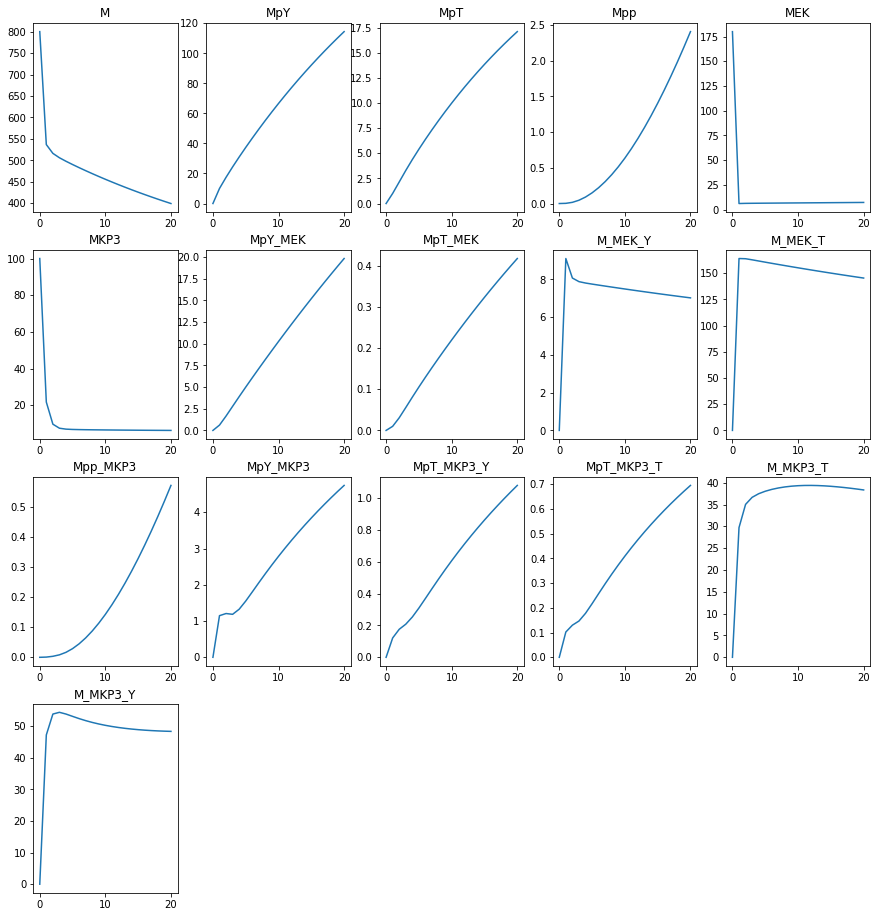

In [16]:
ns = len(model.listOfSpecies)
plt.figure(figsize=(15, 4 * int(math.ceil(ns / 5.0))))
for n, s in enumerate(model.listOfSpecies):
    plt.subplot(int(math.ceil(ns / 5.0)), 5, n + 1)
    plt.plot(dresults[0][:, 0], dresults[0][:, n + 1])
    plt.title(s)

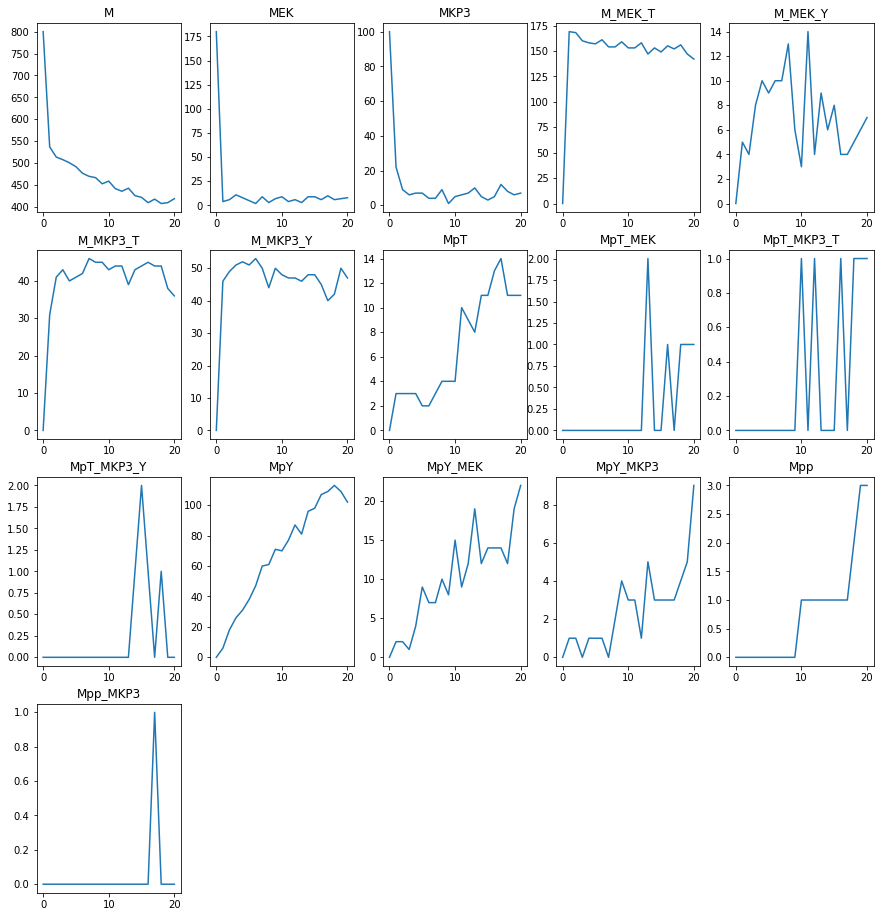

In [17]:
ns = len(stoch_model.listOfSpecies)
plt.figure(figsize=(15, 4 * int(math.ceil(ns / 5.0))))
for n, s in enumerate(stoch_model.listOfSpecies):
    plt.subplot(int(math.ceil(ns / 5.0)), 5, n + 1)
    plt.plot(sresults[0][:, 0], sresults[0][:, n + 1])
    plt.title(s)